In [1]:
import os
import random
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import VGG16_BN_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm
import time

def train(TRAIN_CSV, VAL_CSV, IMAGE_DIR, BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS, DEVICE,
          SEED, SAVE_LAST, SAVE_BEST_ACC, SAVE_BEST_MINCLASS, SAVE_BEST_F1, LR_ADJUSTMENT = False, CLASSIFIER_ONLY = False):
    df_train = pd.read_csv(TRAIN_CSV, low_memory=False)
    classes = sorted(df_train['class'].unique())
    class_to_idx = {c: i for i, c in enumerate(classes)}
    print(f"Found {len(classes)} classes: {classes}")
    
    class CSVDataset(Dataset):
        def __init__(self, csv_file, img_dir, class_to_idx, transform=None):
            self.df = pd.read_csv(csv_file, low_memory=False)
            self.img_dir = Path(img_dir)
            self.class_to_idx = class_to_idx
            self.transform = transform
    
        def __len__(self):
            return len(self.df)
    
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img_path = self.img_dir / row['rel_path'].lstrip('/')
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.class_to_idx[row['class']]
            return image, label
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  
            transforms.Normalize([0.4812775254249573, 0.4674863815307617, 0.4093940854072571],
                                 [0.19709135591983795, 0.1933959424495697, 0.19051066040992737]),
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4812775254249573, 0.4674863815307617, 0.4093940854072571],
                                 [0.19709135591983795, 0.1933959424495697, 0.19051066040992737])
        ])
    }
    
    
    datasets = {
        x: CSVDataset(
            TRAIN_CSV if x == 'train' else VAL_CSV,
            IMAGE_DIR, class_to_idx,
            transform=data_transforms[x]
        ) for x in ['train', 'val']
    }
    
    dl_generator = torch.Generator()
    dl_generator.manual_seed(SEED)
    
    def seed_worker(worker_id):
        worker_seed = SEED + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    dataloaders = {
        x: DataLoader(
            datasets[x],
            batch_size=BATCH_SIZE,
            shuffle=(x == 'train'),
            generator=dl_generator,
            worker_init_fn=seed_worker
        ) for x in ['train', 'val']
    }
    
    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
    print(f"Sizes → Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}")
    
    if SAVE_LAST.exists():
        print(f"Checkpoint found at {SAVE_LAST}, initializing random VGG-16 and loading weights")
        model = models.vgg16_bn(weights=None)
    else:
        print("No checkpoint found; initializing VGG-16 with ImageNet pretrained weights")
        model = models.vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)
    
    model.avgpool = nn.AdaptiveAvgPool2d((7,7))
    model.classifier[6] = nn.Linear(4096, len(classes))
    
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    if CLASSIFIER_ONLY:
        optimizer = optim.AdamW([
            {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}
        ], weight_decay=0.05)
    else:
        optimizer = optim.AdamW([
            {'params': model.features.parameters(), 'lr': LEARNING_RATE * 0.1 if LR_ADJUSTMENT else LEARNING_RATE},
            {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}
        ], weight_decay=0.05)
    
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=2, min_lr=1e-6)
    
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[],
               'train_min_acc':[], 'val_min_acc':[], 'train_f1':[], 'val_f1':[]}
    best_acc = best_f1 = 0.0
    best_min = 0.0
    best_min_ref_acc = 0.0
    start_epoch = 1
    
    if SAVE_LAST.exists():
        checkpoint = torch.load(SAVE_LAST, map_location=DEVICE, weights_only = False)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        best_acc = checkpoint.get('best_acc', 0.0)
        best_min = checkpoint.get('best_min', 0.0)
        best_min_ref_acc = checkpoint.get('best_min_ref_acc', 0.0)
        best_f1 = checkpoint.get('best_f1', 0.0)
        history = checkpoint.get('history', history)
        start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"Resuming from epoch {start_epoch}. Loaded best_min_ref_acc={best_min_ref_acc:.4f}")
    
    t0 = time.time()
    for epoch in range(start_epoch, NUM_EPOCHS+1):
        print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
        print('-'*40)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            all_preds, all_labels = [], []
    
            for inputs, labels in tqdm(dataloaders[phase], desc=phase.capitalize()):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            counts, corrects = [0]*len(classes), [0]*len(classes)
            for t, p in zip(all_labels, all_preds):
                counts[t] += 1
                corrects[t] += (t == p)
            min_rec = min(corrects[i]/counts[i] if counts[i] else 0 for i in range(len(classes)))
            avg_f1 = f1_score(all_labels, all_preds, average='macro')
    
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_min_acc'].append(min_rec)
            history[f'{phase}_f1'].append(avg_f1)
            print(f"{phase.capitalize()} → Loss: {epoch_loss:.4f}, "
                  f"Avg Acc: {epoch_acc:.4f}, Min Acc: {min_rec:.4f}, Avg F1: {avg_f1:.4f}")
    
            if phase == 'val':
                scheduler.step(epoch_loss)
    
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), SAVE_BEST_ACC)
                    print(f"  -> Saved Best Avg-Acc: {best_acc:.4f}")

                if (min_rec > best_min) or (min_rec == best_min and epoch_acc > best_min_ref_acc):
                    prev_min = best_min
                    prev_ref = best_min_ref_acc
                    best_min = min_rec
                    best_min_ref_acc = epoch_acc
                    torch.save(model.state_dict(), SAVE_BEST_MINCLASS)
                    print(f"  -> Saved Best Min-Acc: {best_min:.4f} (was {prev_min:.4f}; ref-acc updated {prev_ref:.4f} -> {best_min_ref_acc:.4f})")
    
                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    torch.save(model.state_dict(), SAVE_BEST_F1)
                    print(f"  -> Saved Best F1: {best_f1:.4f}")
    
        if epoch % 20 == 0:
            torch.save({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'scheduler_state': scheduler.state_dict(),
                'best_acc': best_acc,
                'best_min': best_min,
                'best_min_ref_acc': best_min_ref_acc,
                'best_f1': best_f1,
                'history': history
            }, SAVE_LAST)
            print(f"Checkpoint at epoch {epoch} saved → {SAVE_LAST}")
    
    if NUM_EPOCHS % 20 != 0:
        torch.save({
            'epoch': NUM_EPOCHS,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'best_acc': best_acc,
            'best_min': best_min,
            'best_min_ref_acc': best_min_ref_acc,
            'best_f1': best_f1,
            'history': history
        }, SAVE_LAST)
        print(f"Final checkpoint at epoch {NUM_EPOCHS} saved → {SAVE_LAST}")
    
    print(f"\nTraining complete in {int((time.time()-t0)//60)}m{int((time.time()-t0)%60)}s")
    print(f"Final Bests → Avg Acc: {best_acc:.4f}, Min Acc: {best_min:.4f}, Best-Min Ref Acc: {best_min_ref_acc:.4f}, Avg F1: {best_f1:.4f}")
    
    plt.figure(figsize=(14,6))
    for idx, metric in enumerate(['loss','acc','min_acc','f1']):
        plt.subplot(2,2,idx+1)
        plt.plot(history[f'train_{metric}'], label=f'Train {metric.title()}')
        plt.plot(history[f'val_{metric}'], label=f'Val {metric.title()}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

Device: cuda:0
Found 7 classes: ['bird', 'cat', 'fish', 'frog', 'monkey', 'moth', 'spider']
Sizes → Train: 2799, Val: 350
No checkpoint found; initializing VGG-16 with ImageNet pretrained weights

Epoch 1/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 1.8308, Avg Acc: 0.2808, Min Acc: 0.1654, Avg F1: 0.2792


Val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Val → Loss: 1.3264, Avg Acc: 0.5057, Min Acc: 0.2600, Avg F1: 0.5132
  -> Saved Best Avg-Acc: 0.5057
  -> Saved Best Min-Acc: 0.2600 (was 0.0000; ref-acc updated 0.0000 -> 0.5057)
  -> Saved Best F1: 0.5132

Epoch 2/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 1.4705, Avg Acc: 0.4680, Min Acc: 0.2375, Avg F1: 0.4677


Val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Val → Loss: 1.5073, Avg Acc: 0.5914, Min Acc: 0.3400, Avg F1: 0.5870
  -> Saved Best Avg-Acc: 0.5914
  -> Saved Best Min-Acc: 0.3400 (was 0.2600; ref-acc updated 0.5057 -> 0.5914)
  -> Saved Best F1: 0.5870

Epoch 3/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 1.2252, Avg Acc: 0.5413, Min Acc: 0.3100, Avg F1: 0.5371


Val: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Val → Loss: 1.1383, Avg Acc: 0.6257, Min Acc: 0.4400, Avg F1: 0.6237
  -> Saved Best Avg-Acc: 0.6257
  -> Saved Best Min-Acc: 0.4400 (was 0.3400; ref-acc updated 0.5914 -> 0.6257)
  -> Saved Best F1: 0.6237

Epoch 4/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Train → Loss: 1.1322, Avg Acc: 0.5991, Min Acc: 0.4550, Avg F1: 0.6007


Val: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Val → Loss: 1.1879, Avg Acc: 0.6343, Min Acc: 0.4600, Avg F1: 0.6302
  -> Saved Best Avg-Acc: 0.6343
  -> Saved Best Min-Acc: 0.4600 (was 0.4400; ref-acc updated 0.6257 -> 0.6343)
  -> Saved Best F1: 0.6302

Epoch 5/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 1.0150, Avg Acc: 0.6370, Min Acc: 0.4775, Avg F1: 0.6344


Val: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Val → Loss: 1.0609, Avg Acc: 0.6629, Min Acc: 0.4400, Avg F1: 0.6656
  -> Saved Best Avg-Acc: 0.6629
  -> Saved Best F1: 0.6656

Epoch 6/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.9395, Avg Acc: 0.6649, Min Acc: 0.4975, Avg F1: 0.6670


Val: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Val → Loss: 1.0436, Avg Acc: 0.6943, Min Acc: 0.5600, Avg F1: 0.6941
  -> Saved Best Avg-Acc: 0.6943
  -> Saved Best Min-Acc: 0.5600 (was 0.4600; ref-acc updated 0.6343 -> 0.6943)
  -> Saved Best F1: 0.6941

Epoch 7/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 0.8460, Avg Acc: 0.7045, Min Acc: 0.5825, Avg F1: 0.7043


Val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val → Loss: 1.0740, Avg Acc: 0.6629, Min Acc: 0.4600, Avg F1: 0.6642

Epoch 8/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.7733, Avg Acc: 0.7242, Min Acc: 0.5950, Avg F1: 0.7249


Val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Val → Loss: 1.0798, Avg Acc: 0.7000, Min Acc: 0.5600, Avg F1: 0.6982
  -> Saved Best Avg-Acc: 0.7000
  -> Saved Best Min-Acc: 0.5600 (was 0.5600; ref-acc updated 0.6943 -> 0.7000)
  -> Saved Best F1: 0.6982

Epoch 9/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.7112, Avg Acc: 0.7488, Min Acc: 0.6500, Avg F1: 0.7483


Val: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Val → Loss: 1.0981, Avg Acc: 0.6943, Min Acc: 0.5800, Avg F1: 0.6949
  -> Saved Best Min-Acc: 0.5800 (was 0.5600; ref-acc updated 0.7000 -> 0.6943)

Epoch 10/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Train → Loss: 0.6518, Avg Acc: 0.7724, Min Acc: 0.6575, Avg F1: 0.7722


Val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val → Loss: 1.0596, Avg Acc: 0.7000, Min Acc: 0.5000, Avg F1: 0.7003
  -> Saved Best F1: 0.7003

Epoch 11/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Train → Loss: 0.5902, Avg Acc: 0.7864, Min Acc: 0.6875, Avg F1: 0.7869


Val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Val → Loss: 1.0657, Avg Acc: 0.7171, Min Acc: 0.6000, Avg F1: 0.7183
  -> Saved Best Avg-Acc: 0.7171
  -> Saved Best Min-Acc: 0.6000 (was 0.5800; ref-acc updated 0.6943 -> 0.7171)
  -> Saved Best F1: 0.7183

Epoch 12/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 0.5523, Avg Acc: 0.8117, Min Acc: 0.7150, Avg F1: 0.8112


Val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val → Loss: 1.0467, Avg Acc: 0.7143, Min Acc: 0.5200, Avg F1: 0.7147

Epoch 13/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Train → Loss: 0.5039, Avg Acc: 0.8210, Min Acc: 0.7300, Avg F1: 0.8212


Val: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Val → Loss: 1.0420, Avg Acc: 0.7114, Min Acc: 0.6200, Avg F1: 0.7132
  -> Saved Best Min-Acc: 0.6200 (was 0.6000; ref-acc updated 0.7171 -> 0.7114)

Epoch 14/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Train → Loss: 0.4864, Avg Acc: 0.8299, Min Acc: 0.7200, Avg F1: 0.8304


Val: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Val → Loss: 1.0340, Avg Acc: 0.7229, Min Acc: 0.5800, Avg F1: 0.7231
  -> Saved Best Avg-Acc: 0.7229
  -> Saved Best F1: 0.7231

Epoch 15/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Train → Loss: 0.4631, Avg Acc: 0.8328, Min Acc: 0.7200, Avg F1: 0.8324


Val: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Val → Loss: 1.0185, Avg Acc: 0.7400, Min Acc: 0.6000, Avg F1: 0.7398
  -> Saved Best Avg-Acc: 0.7400
  -> Saved Best F1: 0.7398

Epoch 16/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 0.4400, Avg Acc: 0.8457, Min Acc: 0.7475, Avg F1: 0.8454


Val: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Val → Loss: 1.0386, Avg Acc: 0.7171, Min Acc: 0.6000, Avg F1: 0.7179

Epoch 17/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 0.4252, Avg Acc: 0.8489, Min Acc: 0.7475, Avg F1: 0.8489


Val: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Val → Loss: 1.0694, Avg Acc: 0.7086, Min Acc: 0.5800, Avg F1: 0.7112

Epoch 18/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.3988, Avg Acc: 0.8653, Min Acc: 0.7925, Avg F1: 0.8657


Val: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Val → Loss: 1.0813, Avg Acc: 0.7171, Min Acc: 0.5000, Avg F1: 0.7133

Epoch 19/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.3787, Avg Acc: 0.8714, Min Acc: 0.7925, Avg F1: 0.8708


Val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Val → Loss: 1.0892, Avg Acc: 0.7200, Min Acc: 0.5800, Avg F1: 0.7196

Epoch 20/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.3696, Avg Acc: 0.8707, Min Acc: 0.7725, Avg F1: 0.8703


Val: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Val → Loss: 1.1254, Avg Acc: 0.7057, Min Acc: 0.5600, Avg F1: 0.7073
Checkpoint at epoch 20 saved → Models/32x32/last_checkpoint_vgg16_32x32_Model-2.pth

Epoch 21/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Train → Loss: 0.3105, Avg Acc: 0.8914, Min Acc: 0.8400, Avg F1: 0.8917


Val: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Val → Loss: 1.1833, Avg Acc: 0.7086, Min Acc: 0.5400, Avg F1: 0.7080

Epoch 22/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Train → Loss: 0.3381, Avg Acc: 0.8792, Min Acc: 0.8050, Avg F1: 0.8793


Val: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Val → Loss: 1.2075, Avg Acc: 0.7000, Min Acc: 0.5200, Avg F1: 0.6981

Epoch 23/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.3337, Avg Acc: 0.8796, Min Acc: 0.7875, Avg F1: 0.8793


Val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val → Loss: 1.1575, Avg Acc: 0.7171, Min Acc: 0.5800, Avg F1: 0.7169

Epoch 24/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.3126, Avg Acc: 0.8871, Min Acc: 0.8200, Avg F1: 0.8871


Val: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Val → Loss: 1.1481, Avg Acc: 0.7143, Min Acc: 0.5600, Avg F1: 0.7136

Epoch 25/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.3082, Avg Acc: 0.8946, Min Acc: 0.8375, Avg F1: 0.8948


Val: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Val → Loss: 1.1675, Avg Acc: 0.7171, Min Acc: 0.5800, Avg F1: 0.7171

Epoch 26/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.3102, Avg Acc: 0.8942, Min Acc: 0.8075, Avg F1: 0.8943


Val: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Val → Loss: 1.1884, Avg Acc: 0.7086, Min Acc: 0.5600, Avg F1: 0.7076

Epoch 27/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 0.2881, Avg Acc: 0.8917, Min Acc: 0.8125, Avg F1: 0.8918


Val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Val → Loss: 1.2008, Avg Acc: 0.7086, Min Acc: 0.5400, Avg F1: 0.7073

Epoch 28/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2949, Avg Acc: 0.8982, Min Acc: 0.8325, Avg F1: 0.8984


Val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Val → Loss: 1.1988, Avg Acc: 0.7086, Min Acc: 0.5600, Avg F1: 0.7079

Epoch 29/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2856, Avg Acc: 0.9003, Min Acc: 0.8400, Avg F1: 0.9002


Val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Val → Loss: 1.1993, Avg Acc: 0.7086, Min Acc: 0.5800, Avg F1: 0.7084

Epoch 30/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.2696, Avg Acc: 0.9078, Min Acc: 0.8550, Avg F1: 0.9077


Val: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Val → Loss: 1.1918, Avg Acc: 0.7143, Min Acc: 0.5800, Avg F1: 0.7138

Epoch 31/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2675, Avg Acc: 0.9089, Min Acc: 0.8525, Avg F1: 0.9088


Val: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Val → Loss: 1.1952, Avg Acc: 0.7114, Min Acc: 0.5800, Avg F1: 0.7112

Epoch 32/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Train → Loss: 0.2775, Avg Acc: 0.9071, Min Acc: 0.8575, Avg F1: 0.9072


Val: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Val → Loss: 1.2110, Avg Acc: 0.7029, Min Acc: 0.5400, Avg F1: 0.7025

Epoch 33/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Train → Loss: 0.2629, Avg Acc: 0.9171, Min Acc: 0.8700, Avg F1: 0.9172


Val: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Val → Loss: 1.2204, Avg Acc: 0.7029, Min Acc: 0.5600, Avg F1: 0.7026

Epoch 34/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2562, Avg Acc: 0.9107, Min Acc: 0.8725, Avg F1: 0.9108


Val: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Val → Loss: 1.2122, Avg Acc: 0.7057, Min Acc: 0.5600, Avg F1: 0.7054

Epoch 35/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.2745, Avg Acc: 0.9064, Min Acc: 0.8400, Avg F1: 0.9063


Val: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Val → Loss: 1.2255, Avg Acc: 0.7057, Min Acc: 0.5800, Avg F1: 0.7059

Epoch 36/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Train → Loss: 0.2496, Avg Acc: 0.9196, Min Acc: 0.8625, Avg F1: 0.9194


Val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val → Loss: 1.2127, Avg Acc: 0.7114, Min Acc: 0.5800, Avg F1: 0.7112

Epoch 37/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2669, Avg Acc: 0.9100, Min Acc: 0.8571, Avg F1: 0.9098


Val: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Val → Loss: 1.2345, Avg Acc: 0.7057, Min Acc: 0.5600, Avg F1: 0.7054

Epoch 38/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2717, Avg Acc: 0.9043, Min Acc: 0.8500, Avg F1: 0.9042


Val: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Val → Loss: 1.2484, Avg Acc: 0.7029, Min Acc: 0.5600, Avg F1: 0.7025

Epoch 39/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Train → Loss: 0.2579, Avg Acc: 0.9078, Min Acc: 0.8475, Avg F1: 0.9079


Val: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Val → Loss: 1.2404, Avg Acc: 0.7000, Min Acc: 0.5400, Avg F1: 0.6994

Epoch 40/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2540, Avg Acc: 0.9178, Min Acc: 0.8575, Avg F1: 0.9177


Val: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Val → Loss: 1.2381, Avg Acc: 0.7000, Min Acc: 0.5400, Avg F1: 0.6993
Checkpoint at epoch 40 saved → Models/32x32/last_checkpoint_vgg16_32x32_Model-2.pth

Epoch 41/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2685, Avg Acc: 0.9082, Min Acc: 0.8650, Avg F1: 0.9082


Val: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Val → Loss: 1.2294, Avg Acc: 0.6971, Min Acc: 0.5200, Avg F1: 0.6967

Epoch 42/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2530, Avg Acc: 0.9157, Min Acc: 0.8700, Avg F1: 0.9158


Val: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Val → Loss: 1.2144, Avg Acc: 0.7000, Min Acc: 0.5200, Avg F1: 0.6990

Epoch 43/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2335, Avg Acc: 0.9178, Min Acc: 0.8550, Avg F1: 0.9178


Val: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Val → Loss: 1.2375, Avg Acc: 0.7000, Min Acc: 0.5200, Avg F1: 0.6995

Epoch 44/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2434, Avg Acc: 0.9168, Min Acc: 0.8725, Avg F1: 0.9167


Val: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val → Loss: 1.2323, Avg Acc: 0.7000, Min Acc: 0.5200, Avg F1: 0.6996

Epoch 45/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Train → Loss: 0.2486, Avg Acc: 0.9110, Min Acc: 0.8650, Avg F1: 0.9112


Val: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Val → Loss: 1.2296, Avg Acc: 0.7029, Min Acc: 0.5200, Avg F1: 0.7024

Epoch 46/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Train → Loss: 0.2438, Avg Acc: 0.9164, Min Acc: 0.8700, Avg F1: 0.9166


Val: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Val → Loss: 1.2146, Avg Acc: 0.7029, Min Acc: 0.5200, Avg F1: 0.7024

Epoch 47/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Train → Loss: 0.2494, Avg Acc: 0.9150, Min Acc: 0.8525, Avg F1: 0.9148


Val: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Val → Loss: 1.2208, Avg Acc: 0.7029, Min Acc: 0.5200, Avg F1: 0.7020

Epoch 48/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2280, Avg Acc: 0.9207, Min Acc: 0.8675, Avg F1: 0.9207


Val: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Val → Loss: 1.2217, Avg Acc: 0.7057, Min Acc: 0.5400, Avg F1: 0.7050

Epoch 49/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Train → Loss: 0.2586, Avg Acc: 0.9164, Min Acc: 0.8700, Avg F1: 0.9164


Val: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Val → Loss: 1.2148, Avg Acc: 0.7029, Min Acc: 0.5200, Avg F1: 0.7024

Epoch 50/50
----------------------------------------


Train: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Train → Loss: 0.2646, Avg Acc: 0.9096, Min Acc: 0.8725, Avg F1: 0.9097


Val: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Val → Loss: 1.2266, Avg Acc: 0.7000, Min Acc: 0.5200, Avg F1: 0.6992
Final checkpoint at epoch 50 saved → Models/32x32/last_checkpoint_vgg16_32x32_Model-2.pth

Training complete in 6m29s
Final Bests → Avg Acc: 0.7400, Min Acc: 0.6200, Best-Min Ref Acc: 0.7114, Avg F1: 0.7398


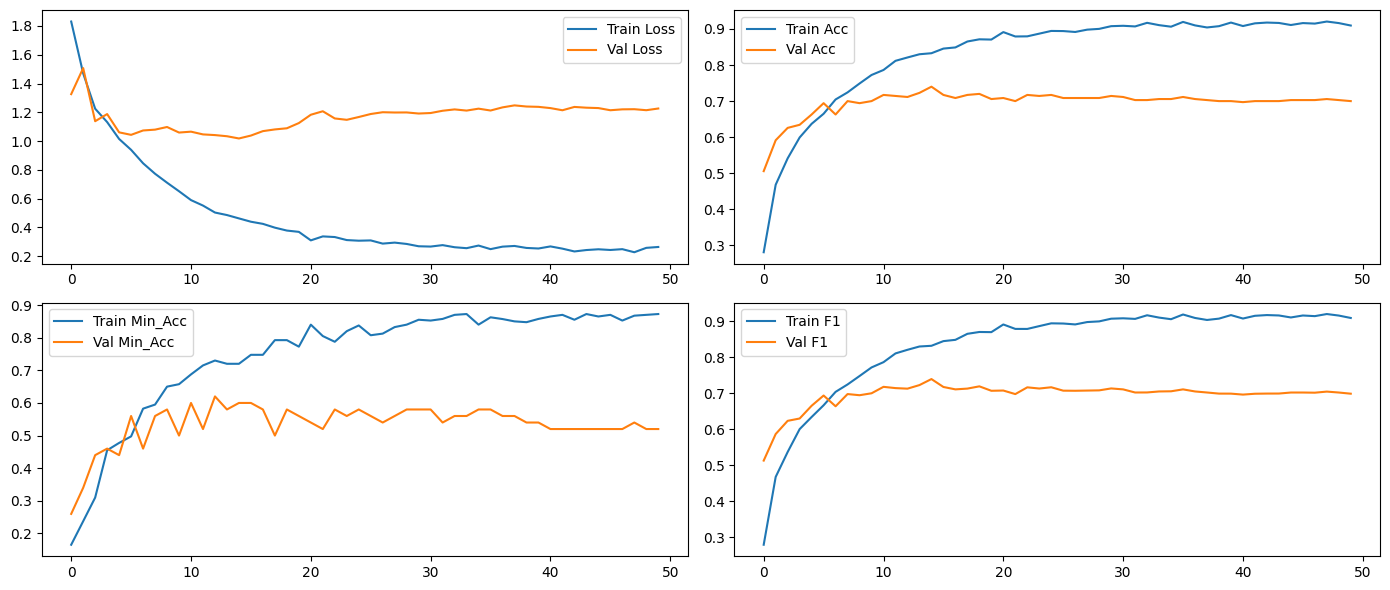

In [6]:
MODEL_NAME    = 'Model-2'
BASE_DIR      = Path("/kaggle/input/datasetinat/01-CleanModel/Dataset")
SIZE          = 32
IMAGE_DIR     = BASE_DIR / f"{SIZE}x{SIZE}"
TRAIN_CSV     = "/kaggle/input/datasetinat/01-CleanModel/Dataset/clean_model_train.csv"
VAL_CSV       = "/kaggle/input/datasetinat/01-CleanModel/Dataset/clean_model_val.csv"
BATCH_SIZE    = 512
NUM_EPOCHS    = 50
LEARNING_RATE = 0.001
DEVICE        = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BaseOutput = f'./Models/{SIZE}x{SIZE}/'

os.makedirs(BaseOutput, exist_ok=True)

SAVE_BEST_ACC      = Path(BaseOutput+f"best_avg_acc_vgg16_{SIZE}x{SIZE}_{MODEL_NAME}.pth")
SAVE_BEST_MINCLASS = Path(BaseOutput+f"best_min_acc_vgg16_{SIZE}x{SIZE}_{MODEL_NAME}.pth")
SAVE_BEST_F1       = Path(BaseOutput+f"best_avg_f1_vgg16_{SIZE}x{SIZE}_{MODEL_NAME}.pth")
SAVE_LAST          = Path(BaseOutput+f"last_checkpoint_vgg16_{SIZE}x{SIZE}_{MODEL_NAME}.pth")
SAVE_FINAL         = Path(BaseOutput+f"final_vgg16_{SIZE}x{SIZE}_{MODEL_NAME}.pth")


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Device: {DEVICE}")

train(TRAIN_CSV, VAL_CSV, IMAGE_DIR, BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS, DEVICE,
          SEED, SAVE_LAST, SAVE_BEST_ACC, SAVE_BEST_MINCLASS, SAVE_BEST_F1, LR_ADJUSTMENT = True, CLASSIFIER_ONLY = False)